# Import Packages

In [77]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report, f1_score, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from matplotlib import pyplot as plt
import seaborn as sns

In [40]:
LABEL_COL = 'Reservation_Status'

In [41]:
TRAIN_SET = '../data/Hotel-A-train.csv'
VAL_SET = '../data/Hotel-A-validation.csv'
TEST_SET = '../data/Hotel-A-test.csv'

In [42]:
df = pd.read_csv(TRAIN_SET, index_col='Reservation-id', parse_dates=['Expected_checkin', 'Expected_checkout'])
df_val = pd.read_csv(VAL_SET, index_col='Reservation-id', parse_dates=['Expected_checkin', 'Expected_checkout'])
df_test = pd.read_csv(TEST_SET, index_col='Reservation-id', parse_dates=['Expected_checkin', 'Expected_checkout'])

In [51]:
df['row_num'] = [i for i in range(df.shape[0])]

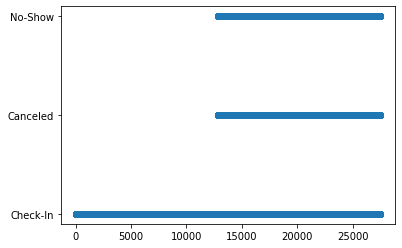

In [53]:
plt.scatter(df.row_num, df.Reservation_Status)

In [55]:
df['row_num_div_100'] = np.floor((df.row_num/100))

<AxesSubplot:xlabel='row_num_div_100', ylabel='Booking_date'>

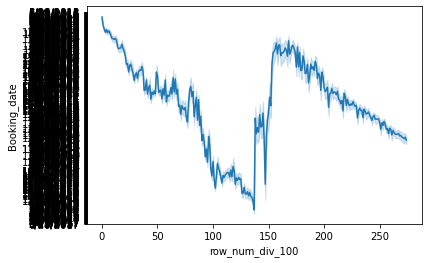

In [88]:
sns.lineplot(x='row_num_div_100', y='Booking_date', data=df)

In [60]:
df_grp = df.groupby('row_num_div_100').Reservation_Status.value_counts()

In [72]:
df_grp.index.names = ['x', 'y']

In [74]:
df_grp_r = df_grp.reset_index()

<AxesSubplot:xlabel='x', ylabel='Reservation_Status'>

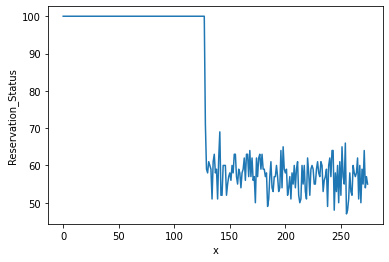

In [79]:
sns.lineplot(x='x', y='Reservation_Status', data=df_grp_r[df_grp_r.y == 'Check-In'])

<AxesSubplot:xlabel='x', ylabel='Reservation_Status'>

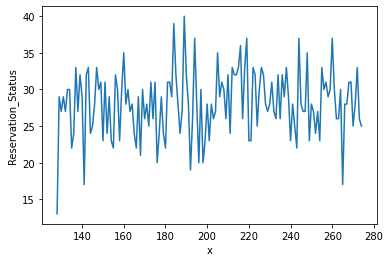

In [82]:
sns.lineplot(x='x', y='Reservation_Status', data=df_grp_r[df_grp_r.y == 'Canceled'])

<AxesSubplot:xlabel='x', ylabel='Reservation_Status'>

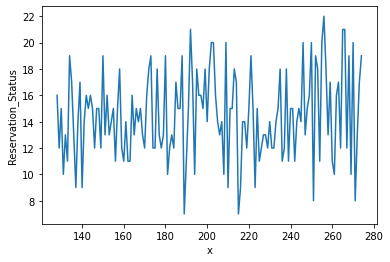

In [83]:
sns.lineplot(x='x', y='Reservation_Status', data=df_grp_r[df_grp_r.y == 'No-Show'])

In [105]:
df = df_val.sample(frac=1)

In [106]:
df['row_num'] = [i for i in range(df.shape[0])]

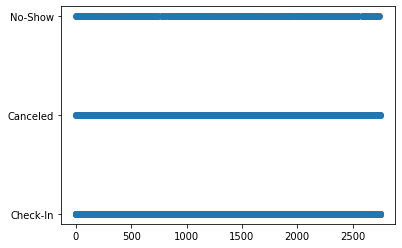

In [107]:
plt.scatter(df.row_num, df.Reservation_Status)

In [108]:
df['row_num_div_100'] = np.floor((df.row_num/100))

<AxesSubplot:xlabel='row_num_div_100', ylabel='Booking_date'>

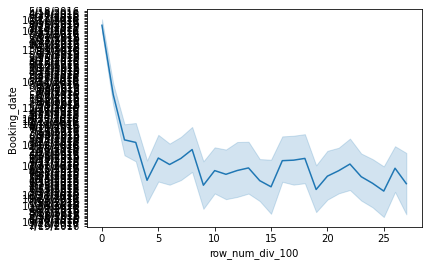

In [109]:
sns.lineplot(x='row_num_div_100', y='Booking_date', data=df)

In [110]:
df_grp = df.groupby('row_num_div_100').Reservation_Status.value_counts()

In [111]:
df_grp.index.names = ['x', 'y']

In [112]:
df_grp_r = df_grp.reset_index()

<AxesSubplot:xlabel='x', ylabel='Reservation_Status'>

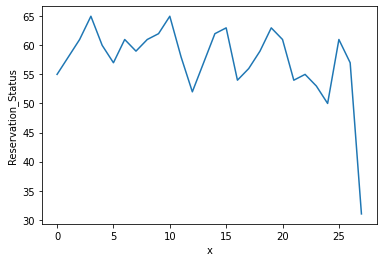

In [113]:
sns.lineplot(x='x', y='Reservation_Status', data=df_grp_r[df_grp_r.y == 'Check-In'])

<AxesSubplot:xlabel='x', ylabel='Reservation_Status'>

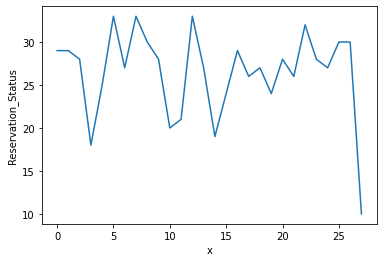

In [114]:
sns.lineplot(x='x', y='Reservation_Status', data=df_grp_r[df_grp_r.y == 'Canceled'])

<AxesSubplot:xlabel='x', ylabel='Reservation_Status'>

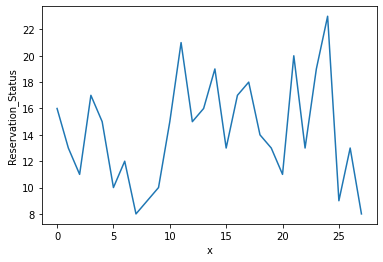

In [115]:
sns.lineplot(x='x', y='Reservation_Status', data=df_grp_r[df_grp_r.y == 'No-Show'])

In [56]:
df.row_num_div_100

Reservation-id
39428300      0.0
77491756      0.0
73747291      0.0
67301739      0.0
77222321      0.0
            ...  
15645505    274.0
56414525    274.0
52023375    274.0
98041387    274.0
55243988    274.0
Name: row_num_div_100, Length: 27499, dtype: float64

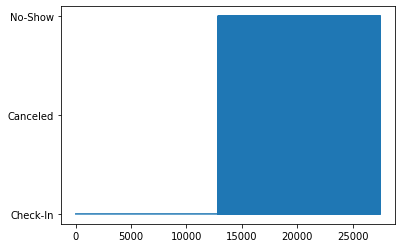

In [50]:
plt.plot([i for i in range(df.shape[0])], df.Reservation_Status)

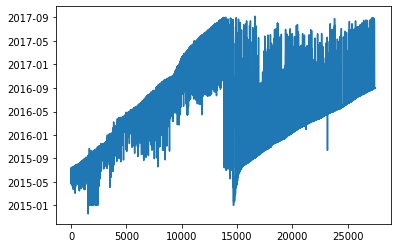

In [48]:
plt.plot([i for i in range(df.shape[0])], df.Expected_checkin)

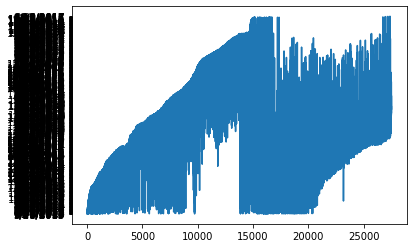

In [49]:
plt.plot([i for i in range(df.shape[0])], df.Booking_date)

In [6]:
df = pd.concat([df, df_val], axis=0)

# Data Preprocessing

## Feature Engineering

In [7]:
df['income_amount'] = df.Income.map({'<25K':25, '50K -- 100K':100, '25K --50K':50, '>100K':200})
df_val['income_amount'] = df_val.Income.map({'<25K':25, '50K -- 100K':100, '25K --50K':50, '>100K':200})
df_test['income_amount'] = df_test.Income.map({'<25K':25, '50K -- 100K':100, '25K --50K':50, '>100K':200})

In [8]:
df['num_rooms'] = np.ceil((df.Adults + df.Children)/5).astype(int)
df_val['num_rooms'] = np.ceil((df_val.Adults + df_val.Children)/5).astype(int)
df_test['num_rooms'] = np.ceil((df_test.Adults + df_test.Children)/5).astype(int)

In [9]:
df['total_cost'] = df.num_rooms*df.Room_Rate
df_val['total_cost'] = df_val.num_rooms*df_val.Room_Rate
df_test['total_cost'] = df_test.num_rooms*df_test.Room_Rate

In [10]:
df['income_ratio'] = df.income_amount/df.total_cost
df_val['income_ratio'] = df_val.income_amount/df_val.total_cost
df_test['income_ratio'] = df_test.income_amount/df_test.total_cost

## Drop columns

In [11]:
drop_cols = ['Expected_checkin', 'Expected_checkout', 'Booking_date', 'num_rooms']

In [12]:
df = df.drop(columns=drop_cols)
df_val = df_val.drop(columns=drop_cols)
df_test = df_test.drop(columns=drop_cols)

In [13]:
df_test[LABEL_COL] = 'abc'

## Categorical encoding

In [14]:
categorical_features_indices = np.where((df.dtypes != np.float) & (df.dtypes != np.int64))[0]

In [15]:
cat_cols = list(set(df.columns[categorical_features_indices].to_list()) - set([LABEL_COL]))

In [16]:
le = OrdinalEncoder(cols=cat_cols)

In [17]:
le.fit(df)

OrdinalEncoder(cols=['Educational_Level', 'Income', 'Country_region',
                     'Use_Promotion', 'Previous_Cancellations', 'Ethnicity',
                     'Visted_Previously', 'Booking_channel',
                     'Required_Car_Parking', 'Hotel_Type', 'Gender',
                     'Deposit_type', 'Meal_Type'],
               mapping=[{'col': 'Educational_Level', 'data_type': dtype('O'),
                         'mapping': Grad           1
Mid-School     2
College        3
High-School    4
NaN           -2
dtype: int...
                        {'col': 'Hotel_Type', 'data_type': dtype('O'),
                         'mapping': City Hotel        1
Airport Hotels    2
Resort            3
NaN              -2
dtype: int64},
                        {'col': 'Gender', 'data_type': dtype('O'),
                         'mapping': F      1
M      2
NaN   -2
dtype: int64},
                        {'col': 'Deposit_type', 'data_type': dtype('O'),
                         'mapping': No 

In [18]:
df = le.transform(df)
df_val = le.transform(df_val)
df_test = le.transform(df_test)

In [19]:
df[cat_cols] = df[cat_cols].astype('category')
df_val[cat_cols] = df_val[cat_cols].astype('category')
df_test[cat_cols] = df_test[cat_cols].astype('category')

# Create Train/Test Dataset

In [20]:
X = df.drop(columns='Reservation_Status')
y = df['Reservation_Status']

In [21]:
val_X = df_val.drop(columns='Reservation_Status')
val_y = df_val['Reservation_Status']

In [22]:
sub_X = df_test.drop(columns='Reservation_Status')

In [23]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)

In [32]:
train_X = X
train_y = y

In [33]:
df.dtypes

Gender                    category
Age                          int64
Ethnicity                 category
Educational_Level         category
Income                    category
Country_region            category
Hotel_Type                category
Adults                       int64
Children                     int64
Babies                       int64
Meal_Type                 category
Visted_Previously         category
Previous_Cancellations    category
Deposit_type              category
Booking_channel           category
Required_Car_Parking      category
Reservation_Status          object
Use_Promotion             category
Discount_Rate                int64
Room_Rate                    int64
income_amount                int64
total_cost                   int64
income_ratio               float64
dtype: object

# Model Training

In [34]:
model = LGBMClassifier(n_estimators=5000, n_jobs=-1, max_depth=3, class_weight='balanced', num_leaves=7
                       , subsample=0.8, random_state=2)

In [35]:
kfold = StratifiedKFold(n_splits=10)

In [36]:
cv_result = cross_val_score(model,
                      train_X, y = train_y, 
                      scoring = make_scorer(f1_score, average='macro'), 
                      cv = kfold, n_jobs=-1)

In [37]:
train_X.shape

(30248, 22)

In [38]:
cv_result.mean()

0.3439862698754158

In [608]:
model.fit(train_X, train_y, eval_set=(test_X, test_y),
          categorical_feature='auto', early_stopping_rounds=100, verbose=0)

c:\users\nisal_105136\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\users\nisal_105136\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=3, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=5000, n_jobs=-1, num_leaves=7,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=0.8, subsample_for_bin=200000,
               subsample_freq=0)

# Model Evaluation

In [609]:
pred_y = model.predict(test_X)
pred_y_train = model.predict(train_X)
pred_y_val = model.predict(val_X)

In [610]:
print(classification_report(test_y, pred_y))

              precision    recall  f1-score   support

    Canceled       0.17      0.29      0.22       805
    Check-In       0.81      0.59      0.68      4249
     No-Show       0.09      0.21      0.13       446

    accuracy                           0.51      5500
   macro avg       0.36      0.36      0.34      5500
weighted avg       0.66      0.51      0.57      5500



In [611]:
print(f1_score(train_y, pred_y_train, average='macro'))

0.5704509580339966


In [612]:
print(f1_score(test_y, pred_y, average='macro'))

0.34175393826692724


In [614]:
print(f1_score(val_y, pred_y_val, average='macro'))

0.34308662526484307


In [577]:
pd.Series(model.feature_importances_, index=train_X.columns).sort_values(ascending=False)

income_ratio              14827
Age                       14696
total_cost                11566
Room_Rate                 10487
Discount_Rate              4720
Adults                     3203
Hotel_Type                 3151
Educational_Level          3000
Booking_channel            2952
Meal_Type                  2860
Country_region             2803
Ethnicity                  2748
Deposit_type               2391
Children                   2190
Babies                     1850
Required_Car_Parking       1386
Gender                     1237
Visted_Previously          1109
Previous_Cancellations      976
Use_Promotion               789
Income                      679
income_amount               308
dtype: int32

In [514]:
df_test

,Gender,Age,Ethnicity,Educational_Level,Income,Country_region,Hotel_Type,Adults,Children,Babies,...,Booking_channel,Required_Car_Parking,Reservation_Status,Use_Promotion,Discount_Rate,Room_Rate,income_amount,num_rooms,total_cost,income_ratio
Reservation-id,,,,,,,,,,,,,,,,,,,,,
39428300,1,40,1,1,1,1,1,2,2,0,...,1,1,Check-In,1,10,218,25,1,218,0.114679
77491756,1,49,1,2,2,2,1,3,3,0,...,1,1,Check-In,2,0,185,100,2,370,0.270270
73747291,1,42,2,1,1,2,1,3,3,0,...,1,1,Check-In,2,0,119,25,2,238,0.105042
67301739,2,25,3,3,3,3,2,4,3,0,...,2,1,Check-In,1,5,144,200,2,288,0.694444
77222321,1,62,1,4,4,2,3,1,1,0,...,3,2,Check-In,1,10,242,50,1,242,0.206612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15645505,1,49,3,2,1,4,1,1,2,1,...,1,1,Check-In,1,10,100,25,1,100,0.250000
56414525,1,49,4,3,4,3,2,2,1,0,...,2,1,No-Show,1,40,194,50,1,194,0.257732
52023375,1,49,1,4,2,3,2,2,1,1,...,3,1,Check-In,1,5,202,100,1,202,0.495050


In [531]:
sub_y = model.predict(sub_X)

In [532]:
sub_y

array(['No-Show', 'No-Show', 'Check-In', ..., 'Canceled', 'Check-In',
       'Check-In'], dtype=object)

In [534]:
df_test['pred_y'] = sub_y

In [537]:
df_test.pred_y

Reservation-id
62931593     No-Show
70586099     No-Show
4230648     Check-In
25192322    Check-In
80931528    Canceled
              ...   
39110574     No-Show
5496554     Check-In
59004046    Canceled
65838682    Check-In
14474101    Check-In
Name: pred_y, Length: 4318, dtype: object

In [539]:
sub_s = df_test.pred_y.map({'Check-In':1, 'Canceled':2, 'No-Show':3})

In [540]:
sub_s.name = 'Reservation_status'

In [546]:
sub_s.to_frame().to_csv('../output/submission_file_11Mar_10_41_pm.csv', header=True)